In [1]:
from comet_ml import Experiment

In [2]:
experiment = Experiment(
    api_key='pFR0ZDxiYAyt5B7JfZiEjBqfB',
    project_name='classification-predict',
    workspace='team-jhb-ss3'
)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/team-jhb-ss3/classification-predict/5e63c2e62c7b47f48747fbf967a01755



In [3]:
import pandas as pd
import numpy as np
import spacy
import re
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
nlp = spacy.load('en_core_web_md')

In [5]:
df = pd.read_csv('train.csv')

In [6]:
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [7]:
print(f'The dataframe consists of {len(df)} entries.')

The dataframe consists of 15819 entries.


In [8]:
# Check for NaN entries
df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [9]:
# Check for empty strings
blanks = []
for index, sentiment, message, tweetid in df.itertuples():
    if message.isspace():
        blanks.append(index)

In [10]:
# Check if there are any blanks in the data
blanks

[]

There appears to be no presence of empty strings in the dataset.

{'web': 'https://www.comet.ml/api/image/download?imageId=445a929966d848f6a3ad6b513c9b94bb&experimentKey=5e63c2e62c7b47f48747fbf967a01755',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=445a929966d848f6a3ad6b513c9b94bb&experimentKey=5e63c2e62c7b47f48747fbf967a01755',
 'imageId': '445a929966d848f6a3ad6b513c9b94bb'}

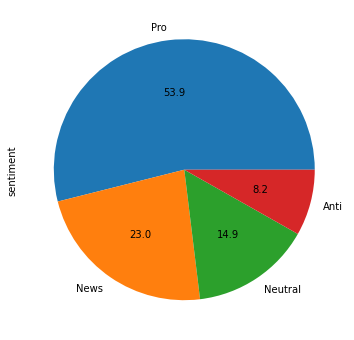

In [13]:
plt.figure(figsize=(6,6))
df['sentiment'].value_counts().plot(kind='pie', autopct='%.1f', labels=['Pro','News','Neutral','Anti'])
experiment.log_figure(figure_name='Sentiment Distribution', figure=plt)

Based on the pie chart, 53.9% of the tweets supports the belief of man-made climate change, 23.0% are based on factual news about climate change, 14,9% of the tweets are rather neutral on the subject, and 8.2% do not believe in man-made climate change.

In [14]:
# To perform a train_test_split to prevent any data leakage going forward
X = df.drop('sentiment', axis=1)
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [15]:
len(X_train)

11073

In [16]:
X_train_copy = X_train['message']

In [17]:
X_train_copy.head()

11131    POLICY SHIFT: Trump to undo Obama’s climate ch...
6119     RT @SenatorDurbin: Rs have demonstrated time &...
9054     RT @BernieSanders: 'The concept of global warm...
11729    RT @ubcforestry: Funding from @GenomeBC will s...
10585    @ANTNAsty22 Does the climate change? Yes; Do w...
Name: message, dtype: object

In [18]:
def retweet_removal(text):
    """
    Returns a retweet message without the RT
    
    Parameters
    -----------
    text: str
        A sentence to be examined
    
    Returns
    --------
    string
        A tweet message without the retweet acronym
    """
    if re.match(r"RT\s+", text): # i.e. if text message starts with RT
        text = re.sub(r"RT\s+","", text)

    return text

In [19]:
# Remove RT which just indicates a retweet
#X_train_copy['message'] = X_train_copy['message'].apply(lambda tweet: retweet_removal(tweet))
X_train_copy = X_train_copy.apply(lambda tweet: retweet_removal(tweet))

In [20]:
# View of the dataframe without retweets
X_train_copy.head()

11131    POLICY SHIFT: Trump to undo Obama’s climate ch...
6119     @SenatorDurbin: Rs have demonstrated time &amp...
9054     @BernieSanders: 'The concept of global warming...
11729    @ubcforestry: Funding from @GenomeBC will supp...
10585    @ANTNAsty22 Does the climate change? Yes; Do w...
Name: message, dtype: object

In [21]:
def symbol_removal(text):
    """
    Returns a tweet message without the @ and # symbol
    
    Parameters
    -----------
    text: str
       A text message 
    """
    
    edited_text = re.sub(r"[@#]", "", text)
    
    return edited_text

In [22]:
# Remove the @ and # symbol from the tweet
X_train_copy = X_train_copy.apply(lambda tweet: symbol_removal(tweet))

In [23]:
# Dataframe without @ and # symbol
X_train_copy.head()

11131    POLICY SHIFT: Trump to undo Obama’s climate ch...
6119     SenatorDurbin: Rs have demonstrated time &amp;...
9054     BernieSanders: 'The concept of global warming ...
11729    ubcforestry: Funding from GenomeBC will suppor...
10585    ANTNAsty22 Does the climate change? Yes; Do we...
Name: message, dtype: object

In [24]:
def remove_punctuations(tweet):
    """
    Returns a tweet without punctuations and words that not in the nltk library

    Parameters
    -----------
    text: str
        A tweet to be examined
    """
    
    tweet = word_tokenize(tweet.lower())
    mylist = []
    
    for word in tweet:
        if nlp.vocab[word].has_vector or nlp.vocab[word].like_num:
            if not nlp.vocab[word].is_punct:
                mylist.append(word)

    return ' '.join(mylist)

In [25]:
# Remove punctuations and words that do not have vectors
X_train_copy = X_train_copy.apply(lambda tweet: remove_punctuations(tweet))

In [26]:
X_train_copy.head()

11131    policy shift trump to undo obama s climate cha...
6119     rs have demonstrated time amp again unwillingn...
9054     concept of global warming was created by and f...
11729    funding from will support 's team as they addr...
10585    does the climate change yes do we know why or ...
Name: message, dtype: object

In [27]:
def prepare_test(test_df):
    """
    Returns processed tweets
    
    Parameters
    ----------
    test_df: DataFrame
        A data frame consisting of tweet messages column
        
    Returns
    --------
    DataFrame
        A data frame with processed tweets
    """
    
    test_df_copy = test_df['message']
    
    # Remove retweets
    test_df_copy = test_df_copy.apply(lambda tweet: retweet_removal(tweet))
    # Remove the @ and # symbol from the tweet
    test_df_copy = test_df_copy.apply(lambda tweet: symbol_removal(tweet))
    # Remove punctuations and words that do not have vectors
    test_df_copy = test_df_copy.apply(lambda tweet: remove_punctuations(tweet))
    
    return test_df_copy

In [28]:
# Length of X_test
len(X_test)

4746

In [29]:
X_test.head()

,message,tweetid
1050,global warming is real,76123
191,"RT @EcoInternet3: U.S. Secretary of State, Rex...",442461
13641,RT @climateprogress: More people than ever are...,344257
580,RT @cathmckenna: 'Instead of debating whether ...,174138
14768,"Climate talks: 'Save us' from global warming, ...",548426


In [30]:
X_test_copy = prepare_test(X_test)

In [31]:
X_test_copy.head()

1050                                global warming is real
191      u.s. secretary of state rex signs arctic agree...
13641    more people than ever are worried about climat...
580      of debating whether reducing carbon emissions ...
14768        climate talks us from global warming us urged
Name: message, dtype: object

In [32]:
tfidf = TfidfVectorizer()

In [33]:
X_train_transformed = tfidf.fit_transform(X_train_copy)

In [41]:
param_grid = {
    'C': [0.1, 0.3, 0.5, 0.7, 0.8, 1]
}

In [42]:
linsvc = LinearSVC()

In [45]:
grid_svc = GridSearchCV(
    estimator=linsvc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

In [46]:
grid_svc.fit(X_train_transformed, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 0.3, 0.5, 0.7, 0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [47]:
grid_svc.best_params_

{'C': 0.5}

In [48]:
best_model = grid_svc.best_estimator_

In [49]:
X_test_transformed = tfidf.transform(X_test_copy)

In [50]:
y_pred_grid = best_model.predict(X_test_transformed)

In [52]:
def metric(actual, predicted):
    """
    Returns valuations metrics for the predictive models
    
    Parameters
    -----------
    actual: list
        list of actual sentiment
    predicted: list
        list of predicted sentiment
    """
    
    f1 = f1_score(actual, predicted, average='weighted')
    print(f"Weighted f1 score: {f1:.2f}")      
    print('\n')
    print('Confusion Matrix')
    print(confusion_matrix(actual, predicted))
    print('\n')
    print('Classification Matrix')
    print(classification_report(actual, predicted))

In [53]:
metric(y_test, y_pred_grid)

Weighted f1 score: 0.72


Confusion Matrix
[[ 153   42  170   23]
 [  30  276  341   66]
 [  34   96 2270  197]
 [   6   17  223  802]]


Classification Matrix
              precision    recall  f1-score   support

          -1       0.69      0.39      0.50       388
           0       0.64      0.39      0.48       713
           1       0.76      0.87      0.81      2597
           2       0.74      0.77      0.75      1048

    accuracy                           0.74      4746
   macro avg       0.70      0.61      0.64      4746
weighted avg       0.73      0.74      0.72      4746



In [54]:
cm = confusion_matrix(y_test, y_pred_grid)

In [55]:
experiment.log_confusion_matrix(labels=['Anti', 'Neutral', 'Pro', 'News'], matrix=cm)

{'web': 'https://www.comet.ml/api/asset/download?assetId=0fd5b921a1534f9a802dce2fcac3f047&experimentKey=5e63c2e62c7b47f48747fbf967a01755',
 'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=0fd5b921a1534f9a802dce2fcac3f047&experimentKey=5e63c2e62c7b47f48747fbf967a01755',
 'assetId': '0fd5b921a1534f9a802dce2fcac3f047'}

In [56]:
f1 = f1_score(y_test, y_pred_grid, average='weighted')
recall = recall_score(y_test, y_pred_grid, average='weighted')
precision = precision_score(y_test, y_pred_grid, average='weighted')

In [57]:
params = {"random_state": 20,
          "model_type": "linear_svc_gridsearched",
          "scaler": 'TfidfVectorizer',
          "param_grid": str(param_grid),
          "stratify": False
          }
metrics = {"f1": f1,
           "recall": recall,
           "precision": precision
           }

In [58]:
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [59]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/team-jhb-ss3/classification-predict/5e63c2e62c7b47f48747fbf967a01755
COMET INFO:   Metrics:
COMET INFO:     f1        : 0.7227945320466611
COMET INFO:     precision : 0.7285614008359229
COMET INFO:     recall    : 0.7376738305941846
COMET INFO:   Parameters [count]:
COMET INFO:     C                 : 0.5
COMET INFO:     class_weight      : 1
COMET INFO:     dual              : True
COMET INFO:     fit_intercept     : True
COMET INFO:     intercept_scaling : 1
COMET INFO:     loss              : squared_hinge
COMET INFO:     max_iter          : 1000
COMET INFO:     model_type        : linear_svc_gridsearched
COMET INFO:     multi_class       : ovr
COMET INFO:     param_grid        : {'C': [0.1, 0.3, 0.5, 0.7, 0.8, 1]}
COMET INFO:     penalty      

In [60]:
test_df = pd.read_csv('test.csv')

In [61]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [62]:
unseen_test = prepare_test(test_df)

In [63]:
unseen_test.head()

0    europe will now be looking to china to make su...
1    combine this with the polling of staffers re c...
2    the scary unimpeachable evidence that climate ...
3    karoli dailykos putin got to you too jill trum...
4              orgasms cause global warming republican
Name: message, dtype: object

In [66]:
predictions = best_model.predict(tfidf.transform(unseen_test))

In [67]:
set(predictions)

{-1, 0, 1, 2}

In [68]:
submission = pd.read_csv('sample_submission.csv')

In [69]:
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [70]:
submission['sentiment'] = predictions

In [71]:
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [72]:
submission.to_csv('linear_SVC_grid.csv', index=False)